# Goals

### - Identify what is driving log error
### - Build a model to accurately predict the log error

# Hypotheses
What we think causes log error:
- Location: certain geographic areas may be harder to accurately predict than others. Log error may differ by County. 
- Property Value: higher valued properties may have more variance which makes them harder to predict
- Age of Property: newer homes may be similarily built, thus easier to predict price. Older property values may have more variance, thus making them harder to predict
- Amenities: fireplace, pool, hot tub, and garage are nice amenities that not all properties include. These amenities may be driving log error by making property values harder to predict.

## Set up Environment

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="white", palette="muted")
#import acquire
import prep
import split_scale
import model
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from math import sqrt
from sklearn.cluster import KMeans
from sklearn.cluster import dbscan
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score





import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import warnings
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Acquisition


### In this section we acquire our data from the SQL database. 

### We  choose to filter on the following conditions based on the requirements of this project:
- Only include properties containing latitude and longitude values.
- Only include properties with a transaction in 2017 (using the most recent transaction date to avoid duplicates).
- Only include single unit properties. 
  - Single unit property: a free standing property in which the owner also owns the land beneath the property. A single unit property is built for the use of one family (i.e. does not include duplexes, triplexes, etc.)
  
  #### Due to unforseen SQL server issues, we completed this project using a csv exported through SQL. This csv is located in our repository. This project remains reproducible both the csv and our acquire.py function. 

Read in the data:

In [2]:
data = pd.read_csv('query_result.csv')

Check the size of the data: 52,357 rows and 61 columns.

In [3]:
data.shape

(52357, 61)

Preview the first five rows:

In [4]:
data.head(5)

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate
0,14297519,1727539,NaN,NaN,NaN,3.5,4,NaN,NaN,3.5,...,485713.0,1023282.0,2016,537569.0,11013.72,NaN,NaN,6.059063e+13,0.025595,2017-01-01
1,17052889,1387261,NaN,NaN,NaN,1.0,2,NaN,NaN,1.0,...,88000.0,464000.0,2016,376000.0,5672.48,NaN,NaN,6.111001e+13,0.055619,2017-01-01
2,14186244,11677,NaN,NaN,NaN,2.0,3,NaN,NaN,2.0,...,85289.0,564778.0,2016,479489.0,6488.30,NaN,NaN,6.059022e+13,0.005383,2017-01-01
3,12177905,2288172,NaN,NaN,NaN,3.0,4,NaN,8.0,3.0,...,108918.0,145143.0,2016,36225.0,1777.51,NaN,NaN,6.037300e+13,-0.103410,2017-01-01
4,12095076,781532,1.0,NaN,NaN,3.0,4,NaN,9.0,3.0,...,276684.0,773303.0,2016,496619.0,9516.26,NaN,NaN,6.037461e+13,-0.001011,2017-01-01


Preview the column names:

In [5]:
data.columns

Index(['parcelid', 'id', 'airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardb

# Preparation
### In this section we prepare the data for exploration and modeling by doing the following:
- Drop columns missing excessive amounts of data
- Impute missing values for columns missing only a small portion of data
- Treat outliers

### Preview nulls

This function shows the amount of rows that have null values for each column. We use this to get an idea of which columns will likely be dropped due to insufficient data. 

In [6]:
prep.nulls_by_col(data)

,num_rows_missing,pct_rows_missing
parcelid,0,0.000000
id,0,0.000000
airconditioningtypeid,38738,0.739882
architecturalstyletypeid,52287,0.998663
basementsqft,52310,0.999102
bathroomcnt,0,0.000000
bedroomcnt,0,0.000000
buildingclasstypeid,52357,1.000000
buildingqualitytypeid,18692,0.357011
calculatedbathnbr,162,0.003094


## Running the data through our prepare function acheives the following:
- drops 40 columns due to excess nulls, redundancy, and irrelevency
- removes properties with tax dollar value count greater than $1 million
- removes properties with a log error less than negative one or greater than 1
- fills nulls with zero for fireplacecnt, garagecarcnt, poolcnt, and taxdelinquencyyear
- impute missing values based on mode: regionidcity
- impute missing values based on mean: calculatedfinishedsquarefeet, lotsizesquarefeet, regionidzip, and yearbuilt
- encodes the fips columns
- fills nulls in taxdelinquencyflag with 'N'
#### Result: Our data is transformed from 52,357 rows x 61 columns to 46,756 rows x 21 columns

In [7]:
data = prep.prep_zillow(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52357 entries, 0 to 52356
Data columns (total 61 columns):
parcelid                        52357 non-null int64
id                              52357 non-null int64
airconditioningtypeid           13619 non-null float64
architecturalstyletypeid        70 non-null float64
basementsqft                    47 non-null float64
bathroomcnt                     52357 non-null float64
bedroomcnt                      52357 non-null int64
buildingclasstypeid             0 non-null float64
buildingqualitytypeid           33665 non-null float64
calculatedbathnbr               52195 non-null float64
decktypeid                      389 non-null float64
finishedfloor1squarefeet        4371 non-null float64
calculatedfinishedsquarefeet    52250 non-null float64
finishedsquarefeet12            52084 non-null float64
finishedsquarefeet13            0 non-null float64
finishedsquarefeet15            0 non-null float64
finishedsquarefeet50            4371 n

Check the size of the data: 46,756 rows and 21 columns.

In [8]:
data.shape

(46756, 21)

Remaining columns:

In [9]:
data.dtypes

parcelid                        float64
bathroomcnt                     float64
bedroomcnt                      float64
calculatedfinishedsquarefeet    float64
fips                            float64
fireplacecnt                    float64
garagecarcnt                    float64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
poolcnt                         float64
propertylandusetypeid           float64
regionidcity                    float64
regionidcounty                  float64
regionidzip                     float64
roomcnt                         float64
yearbuilt                       float64
taxvaluedollarcnt               float64
taxdelinquencyflag              float64
taxdelinquencyyear              float64
logerror                        float64
dtype: object

Preview the first five rows:

In [10]:
data.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,fireplacecnt,garagecarcnt,latitude,longitude,lotsizesquarefeet,...,propertylandusetypeid,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,taxvaluedollarcnt,taxdelinquencyflag,taxdelinquencyyear,logerror
1,0.040395,0.1,0.181818,0.170492,1.0,0.2,0.111111,0.750024,0.088111,0.001780,...,1.0,0.024423,0.426997,0.003678,0.416667,0.644928,0.463493,0.0,0.0,0.527285
2,0.022133,0.2,0.272727,0.142183,0.5,0.0,0.222222,0.369076,0.858200,0.001176,...,1.0,0.045593,0.000000,0.003609,0.500000,0.608696,0.564378,0.0,0.0,0.502109
3,0.009339,0.3,0.363636,0.286662,0.0,0.0,0.000000,0.611955,0.637712,0.001837,...,1.0,0.999987,1.000000,0.001146,0.000000,0.666667,0.144296,0.0,0.0,0.447587
4,0.008812,0.3,0.363636,0.361387,0.0,0.0,0.000000,0.544318,0.669869,0.009004,...,1.0,0.110740,1.000000,0.001024,0.000000,0.521739,0.773125,0.0,0.0,0.498905
5,0.008646,0.1,0.181818,0.077786,0.0,0.0,0.000000,0.547032,0.638432,0.000571,...,1.0,0.106766,1.000000,0.001129,0.000000,0.318841,0.217784,0.0,0.0,0.550391


# Exploration

Simple correlation matrix

In [11]:
data.corr()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,fireplacecnt,garagecarcnt,latitude,longitude,lotsizesquarefeet,...,propertylandusetypeid,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,taxvaluedollarcnt,taxdelinquencyflag,taxdelinquencyyear,logerror
parcelid,1.000000,0.067556,0.074868,0.072101,0.529092,0.339291,0.445554,-0.169301,-0.072063,-0.013919,...,0.006671,-0.027347,-0.387681,0.028324,0.424093,0.164711,0.088846,-0.044317,-0.044091,0.007230
bathroomcnt,0.067556,1.000000,0.624234,0.799004,0.158046,0.160012,0.220746,0.049647,0.005006,0.014869,...,0.043571,-0.060170,-0.161191,0.033891,0.132278,0.540522,0.399990,-0.060032,-0.057925,0.027636
bedroomcnt,0.074868,0.624234,1.000000,0.629117,0.156628,0.151163,0.199923,0.048408,-0.007811,0.001828,...,0.060512,-0.049474,-0.140770,0.021056,0.203176,0.371836,0.236200,-0.045336,-0.044308,0.039754
calculatedfinishedsquarefeet,0.072101,0.799004,0.629117,1.000000,0.162633,0.199747,0.227626,0.031712,-0.002917,0.025447,...,-0.004926,-0.058061,-0.158700,0.029220,0.149093,0.475770,0.460109,-0.049351,-0.047788,0.027443
fips,0.529092,0.158046,0.156628,0.162633,1.000000,0.620868,0.872777,-0.239963,-0.192006,-0.016702,...,0.013060,-0.062120,-0.793113,0.054662,0.831342,0.327296,0.188679,-0.080075,-0.079558,0.012689
fireplacecnt,0.339291,0.160012,0.151163,0.199747,0.620868,1.000000,0.534191,-0.066052,-0.224796,-0.003863,...,0.008208,-0.027174,-0.409872,0.029183,0.619804,0.203245,0.165260,-0.051517,-0.050704,0.000632
garagecarcnt,0.445554,0.220746,0.199923,0.227626,0.872777,0.534191,1.000000,-0.435377,0.131245,-0.019327,...,0.014942,-0.070075,-0.907746,0.055704,0.810130,0.373620,0.233785,-0.081790,-0.080438,0.013678
latitude,-0.169301,0.049647,0.048408,0.031712,-0.239963,-0.066052,-0.435377,1.000000,-0.531718,0.056274,...,-0.007823,-0.017105,0.572667,0.018068,-0.306809,0.111885,-0.175405,0.035346,0.034828,-0.011473
longitude,-0.072063,0.005006,-0.007811,-0.002917,-0.192006,-0.224796,0.131245,-0.531718,1.000000,-0.010717,...,-0.002308,-0.006678,-0.341575,0.028224,-0.018859,0.078307,0.003146,0.004240,0.005001,0.013516
lotsizesquarefeet,-0.013919,0.014869,0.001828,0.025447,-0.016702,-0.003863,-0.019327,0.056274,-0.010717,1.000000,...,0.000077,-0.009244,0.024580,0.004698,-0.015408,0.029830,-0.001680,-0.000874,-0.000714,0.008460


| Variable | Logerror Correlation (absolute value)   |
|----|----|
|logerror| 1|
|bedroomcnt|	0.039754|
|poolcnt	|0.036842|
|taxvaluedollarcnt|	0.02888|
|bathroomcnt|	0.027636|
|calculatedfinishedsquarefeet|	0.027443|
|taxdelinquencyflag|	0.025705|
|taxdelinquencyyear|	0.020211|
|regionidcounty|	0.017184|
|yearbuilt|	0.015641|
|roomcnt|	0.014843|
|garagecarcnt|	0.013678|
|longitude|	0.013516|
|fips|	0.012689|
|latitude|	0.011473|
|propertylandusetypeid|	0.009699|
|lotsizesquarefeet|	0.00846|
|parcelid|	0.00723|
|regionidcity|	0.004214|
|regionidzip|	0.001032|
|fireplacecnt|	0.000632|

### Property Value

fips
0.0    0.505380
0.5    0.507641
1.0    0.506357
Name: logerror, dtype: float64
0.0    30463
0.5    12259
1.0     4034
Name: fips, dtype: int64


Text(0.5, 0.98, 'Log Error and Home Value by County')

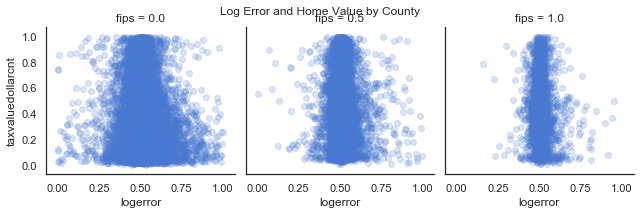

In [12]:
print(data.groupby('fips')['logerror'].mean())
print(data['fips'].value_counts())

g = sns.FacetGrid(data, col = 'fips')
g = g.map(plt.scatter, 'logerror', 'taxvaluedollarcnt', alpha = .2)
g.fig.suptitle("Log Error and Home Value by County")

### Age of Property

Text(0.5, 1.0, 'Does Age of Property effect Log Error?')

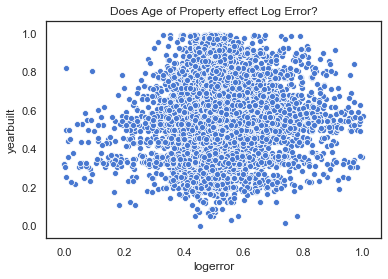

In [13]:
ax = sns.scatterplot(x='logerror',y='yearbuilt', data = data)
ax.set_title("Does Age of Property effect Log Error?")

   k           sse
0  1  35835.363729
1  2  19694.499239
2  3  15177.258872
3  4  12261.860230
4  5  10058.121808
5  6   8747.039763
6  7   7934.338660
7  8   7217.398440
8  9   6518.529915


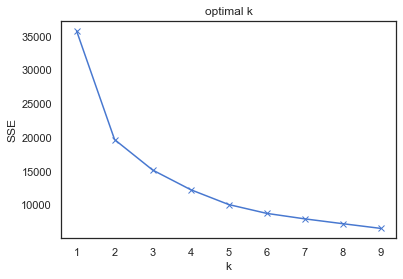

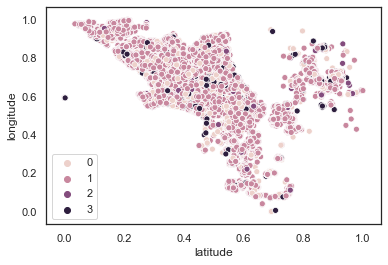

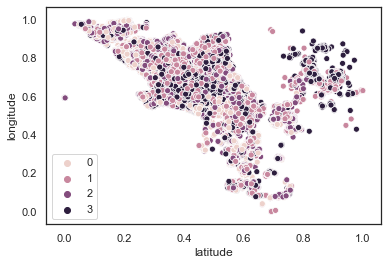

In [14]:

def cluster_zillow(data, return_type = 1):
    kmeans = KMeans(n_clusters = 4)
    encoder = LabelEncoder()
    scaler = MinMaxScaler()
    train, test = train_test_split(data, random_state = 123)
    if return_type == 2:
        kmeans.fit(train[['logerror']])
    if return_type == 1:
        kmeans.fit(train[['taxvaluedollarcnt']])
    scaler.fit_transform(train)
    train['cluster_group'] = kmeans.labels_
    #print('AVERAGE LOG ERROR BY CLUSTER \n%s' % (train.groupby(kmeans.labels_)['logerror'].mean()))
    train['cluster'] = kmeans.labels_
    #g = sns.FacetGrid(train, col = 'cluster')
    #g = g.map(plt.scatter, 'latitude', 'longitude', alpha = .5)
    sns.scatterplot('latitude', 'longitude', data = train, hue=kmeans.labels_, c = 'green')
    
    plt.show()
    return train, test


def inertia_cluster(df):
    ks = range(1,10)
    sse = []
    for k in ks:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(df)
        sse.append(kmeans.inertia_)
    print(pd.DataFrame(dict(k=ks, sse=sse)))
    plt.plot(ks, sse, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('optimal k')
    plt.show()
#train, test = cluster_zillow(data)


inertia_cluster(data)
train, test = cluster_zillow(data, return_type = 2)
train, test = cluster_zillow(data, return_type = 1)

### Finding: 
- There is no direct correlation between log error and year built. We hypothesized that newer home prices would be easier to predict and older homes would have greater log errors. This chart does not support those findings. 

# Modeling

## Split Data

In [15]:
train, test = split_scale.split_my_data(data)
train = prep.zillow_scale(train)


In [16]:
X_train = train.drop(columns=['logerror'])
y_train = train[['logerror']]

In [17]:
X_test = test.drop(columns=['logerror'])
y_test = test['logerror']

## Scale Data

In [18]:
X_train_scaled = split_scale.min_max_scaler(X_train)
y_train_scaled = split_scale.min_max_scaler(y_train)

### Baseline
#### Our baseline will be the mean log error. If we were to predict the mean log error for each property, how effective of a model would we have? 

In [19]:
baseline = pd.DataFrame({'actual':y_train.logerror}).reset_index(drop=True)
baseline['baseline'] = y_train.mean()[0]
baseline.head()

,actual,baseline
0,0.492654,0.506051
1,0.517621,0.506051
2,0.517002,0.506051
3,0.540456,0.506051
4,0.524998,0.506051


In [20]:
MSE_baseline = mean_squared_error(baseline.actual, baseline.baseline)
RMSE_baseline = sqrt(MSE_baseline)
print('RMSE:', RMSE_baseline)

RMSE: 0.0567378132266


### Model 1
- Linear regression with all 20 features

In [21]:
lm1=LinearRegression()
lm1.fit(X_train_scaled, y_train_scaled)
yhat_lm1=lm1.predict(X_train_scaled)
yhat_lm1

array([[0.50948669],
       [0.50268382],
       [0.5026168 ],
       ...,
       [0.51217331],
       [0.50011667],
       [0.49877007]])

In [22]:
MSE_1 = mean_squared_error(yhat_lm1, y_train)
RMSE_1 = sqrt(MSE_1)
print('RMSE:' ,RMSE_1)

RMSE: 0.05650539605276414


### Model 2
- Linear regression with top 6 features: bedroomcnt, poolcnt, taxvaluedollarcnt, bathroomcnt, calculatedfinishedsquarefeet, taxdelinquencyflag

In [23]:
X_train_2 = X_train_scaled[['bedroomcnt','poolcnt', 'taxvaluedollarcnt', 'calculatedfinishedsquarefeet', 'taxdelinquencyflag']]
lm2=LinearRegression()
lm2.fit(X_train_2,y_train_scaled)
yhat_lm2=lm2.predict(X_train_2)
yhat_lm2

array([[0.51178181],
       [0.5028749 ],
       [0.50428666],
       ...,
       [0.51047568],
       [0.50178783],
       [0.50112054]])

In [24]:
MSE_2 = mean_squared_error(yhat_lm2, y_train)
RMSE_2 = sqrt(MSE_2)
print('RMSE:',RMSE_2)

RMSE: 0.05656078462843578


In [35]:
tree = DecisionTreeRegressor(max_depth = 6, random_state = 123)
tree.fit(X_train_scaled, y_train)
y_pred_t = tree.predict(X_train_scaled)

In [36]:
MSE_4 = mean_squared_error(y_train, y_pred_t)
RMSE_4 = sqrt(MSE_4)
print('RMSE:',RMSE_4)

RMSE: 0.05576253399653005


### Model 3
- Random Forest

In [37]:
forest = RandomForestRegressor(max_depth = 8, random_state = 123).fit(X_train_scaled, y_train)
y_pred_for = forest.predict(X_train_scaled)

In [38]:
MSE_3 = mean_squared_error(y_train, y_pred_for)
RMSE_3 = sqrt(MSE_3)
print('RMSE:',RMSE_3)

RMSE: 0.05463516130409284


Apply best model to test data

In [39]:
forest = RandomForestRegressor(max_depth = 8, random_state = 123).fit(X_train_scaled, y_train)
y_pred_for = forest.predict(X_test)

In [40]:
MSE_3 = mean_squared_error(y_test, y_pred_for)
RMSE_3 = sqrt(MSE_3)
print('RMSE:',RMSE_3)

RMSE: 0.05714264450764453


# Conclusions

- tax value has a large effect on log error
- clustering by tax value generates our most accurate model
- our model performs marginally better than the mean baseline on training data, but fails to out perform baseline on test data. 